## 1. Preparation

Download and preprocess the BDD100k dataset, the steps equal the ones found in the [bdd100k.ipynb](https://github.com/nyikovicsmate/thesis/blob/dev/utils/datasets/bdd100k.ipynb) dataset preparation notebook.

In [1]:
# get the dynamic download link
!curl -s "https://2x5kv9t5uf.execute-api.us-west-2.amazonaws.com/production?func=create_download_challenge_link&filename=bdd100k"%"2Fbdd100k_images.zip" -H "Accept: */*" -o uri.txt
# download the dataset (approx 6.5G)
!xargs -n 1 curl -o "bdd100k_images.zip" < uri.txt
# extract
!unzip -q bdd100k_images.zip -d bdd100k_images

# if there is a problem with unzipping it's most likely caused by a failed download
# this can happen when colab is a little too slow to start the download and the dynamic download link expires
# if this happens just try running the cell again

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6619M  100 6619M    0     0  37.1M      0  0:02:58  0:02:58 --:--:-- 39.1M


In [0]:
# move things around
!mv ./bdd100k_images/bdd100k/images/100k ./images 

In [0]:
# cleanup
!rm uri.txt
!rm bdd100k_images.zip
!rm -rf ./bdd100k_images
!rm -rf sample_data

In [0]:
# download the preprocesing script
!curl -s -O https://raw.githubusercontent.com/nyikovicsmate/thesis/dev/utils/preprocess.py
# download requirements.txt
!curl -s -O https://raw.githubusercontent.com/nyikovicsmate/thesis/dev/utils/requirements.txt

In [5]:
!pip3 install -r requirements.txt

     |████████████████████████████████| 61kB 3.1MB/s 
     |████████████████████████████████| 2.9MB 13.8MB/s 
     |████████████████████████████████| 1.6MB 41.9MB/s 
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow~=2.1.0, but you'll have tensorflow 1.15.0 which is incompatible.
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: tqdm 4.28.1
    Uninstalling tqdm-4.28.1:
      Successfully uninstalled tqdm-4.28.1
  Found existing installation: h5py 2.8.0
    Uninstalling h5py-2.8.0:
      Successfully uninstalled h5py-2.8.0


In [6]:
!python3 preprocess.py -h

usage: preprocess.py [-h] [-a AUGMENT_VALUE] [-f {png,hdf,lmdb}] [-g]
                     [-m {clip,clip_rnd,scale,scale_rnd}] [-n NAME]
                     [-s SIZE SIZE]
                     [root]

positional arguments:
  root                  The root directory from where the search for images
                        starts. (default: '.)'

optional arguments:
  -h, --help            show this help message and exit
  -a AUGMENT_VALUE, --augment AUGMENT_VALUE
                        Besides preprocessed images, store augmented ones as
                        well. Augmented image is a processed image with every
                        2nd pixel (in a checkerboard pattern) set to
                        augment_value [0-255].
  -f {png,hdf,lmdb}, --format {png,hdf,lmdb}
                        Output format to use. Supported: png, hdf, lmdb.
                        (default: png)
  -g, --grayscale       Grayscale images.
  -m {clip,clip_rnd,scale,scale_rnd}, --method {clip,clip_rnd

In [7]:
# preprocess the dataset
!python3 preprocess.py -n "bdd100k_hdf" -f "hdf" -m "clip" -g -s 70 70 
!python3 preprocess.py -n "bdd100k_lmdb" -f "lmdb" -m "clip" -g -s 70 70 
!python3 preprocess.py -n "bdd100k_png" -f "png" -m "clip" -g -s 70 70 

Looking for images under /content
Found 100000 images.
Processing images.
100% 100000/100000 [22:17<00:00, 74.77it/s]
Done.
Looking for images under /content
Found 100000 images.
Processing images.
100% 100000/100000 [31:14<00:00, 53.36it/s]
Done.
Looking for images under /content
Found 100000 images.
Processing images.
100% 100000/100000 [19:42<00:00, 84.58it/s]
Done.


## 2. Benchmarking

This point all 3 formats contain the same 100000 70x70 px grayscale images. The benchmarks are focused on the following 4 details of each format:

1.   the **disk size** of the dataset
2.   random **single image** read speed
3.   **sequential batch** read speed 
4.   **random batch** read speed


1.   **disk size benchmark**: calculating the hard disk space the dataset in the given format occupies.
2.   **single image read benchmark**: given 100 random indexes in the range of (0, 100000) measuring how long does it take on average to read one.
3. **sequential batch benchmark**: with a batch size of 100 indexes, and with the indexes being sequentially ordered (e.g. 1st batch (0-99), 2nd (100-199) and so on), measuring how long does it take to read the the first 10000 items into memory.
4. **random batch benchmark**: with a batch size of 100 indexes, and the indexes in each batch are in a random order, measuring how long does it take to read the the first 10000 items into memory.


In [0]:
import pathlib
import h5py
import lmdb
import cv2
from google.colab.patches import cv2_imshow
import pickle
from typing import List, Tuple
import numpy as np
import time
import subprocess


### helper functions


def get_size(path: pathlib.Path):
    """
    Returns the size of a file/directory in MB.
    """
    size = subprocess.check_output(['du','-sh', path]).split()[0].decode('utf-8')
    return size

def get_random_batch() -> np.ndarray:
    """
    Returns a 100 indexes from the range of (0,100000).
    """
    return np.random.randint(0, 100000, 100)

def get_sequential_batches() -> np.ndarray:
    """
    Returns a 100 batches of 100 sequential indexes covering the range of (0,10000).
    """
    idxs = np.arange(0, 10000)
    batches = np.reshape(idxs, (100, 100))
    return batches

def get_random_batches() -> np.ndarray:
    """
    Returns a 100 batches of 100 random indexes covering the range of (0,100000).
    """
    idxs = np.arange(0, 100000)[:10000]
    np.random.shuffle(idxs)
    batches = np.reshape(idxs, (100, 100))
    return batches


### single image read functions 


def read_single_png(idx: int):
    """
    Utility function for reading an image back into memory.
    """
    image_path = pathlib.Path.joinpath(pathlib.Path.cwd(), "bdd100k_png", "images", f"{idx}.png")
    return np.array(cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE))

def read_single_hdf(idx: int):
    """
    Utility function for reading an image back into memory from a .h5 file.
    """
    with h5py.File(pathlib.Path.joinpath(pathlib.Path.cwd(), "bdd100k_hdf.h5"), "r") as file:
        image = np.array(file["images"][idx])
    return image

def read_single_lmdb(idx: int):
    """
    Utility function for reading an image back into memory from a lmdb database.
    """
    lmdb_dir = pathlib.Path.joinpath(pathlib.Path.cwd(), "bdd100k_lmdb")
    env = lmdb.open(str(lmdb_dir), readonly=True, max_dbs=2, readahead=False)
    db = env.open_db(key="images".encode("utf8"))
    with env.begin(db=db) as txn:
        data = txn.get(f"{idx}".encode("utf8"))
        image = pickle.loads(data)
    env.close()
    return image


### sequential batch read functions


def read_sequential_png(idxs: List[int]):
    return [read_single_png(idx) for idx in idxs]

def read_sequential_hdf(idxs: List[int]):
    with h5py.File(pathlib.Path.joinpath(pathlib.Path.cwd(), "bdd100k_hdf.h5"), "r") as file:
        # h5py supports index ranges, read times are significantly faster 
        # than reading each image separately 
        images = np.array(file["images"][idxs])
    return images

def read_sequential_lmdb(idxs: List[int]):
    lmdb_dir = pathlib.Path.joinpath(pathlib.Path.cwd(), "bdd100k_lmdb")
    images = []
    # set readahead to True to fully utilize underlying os capabilities  
    env = lmdb.open(str(lmdb_dir), readonly=True, max_dbs=2, readahead=True) 
    db = env.open_db(key="images".encode("utf8"))
    with env.begin(db=db) as txn:
        for idx in idxs:
            data = txn.get(f"{idx}".encode("utf8"))
            image = pickle.loads(data)
            images.append(image)
    env.close()
    return images


### random batch read functions 


def read_random_png(idxs: List[int]):
    return read_sequential_png(idxs)

def read_random_hdf(idxs: List[int]):
    idxs = list(sorted(idxs))
    with h5py.File(pathlib.Path.joinpath(pathlib.Path.cwd(), "bdd100k_hdf.h5"), "r") as file:
        # h5py still supports index ranges, read times are significantly faster 
        # than reading each image separately 
        # but with random indexes the indexes must be in ascending order
        images = np.array(file["images"][idxs])
    return images

def read_random_lmdb(idxs: List[int]):
    lmdb_dir = pathlib.Path.joinpath(pathlib.Path.cwd(), "bdd100k_lmdb")
    images = []
    # set readahead to False to speed up random reads  
    env = lmdb.open(str(lmdb_dir), readonly=True, max_dbs=2, readahead=False) 
    db = env.open_db(key="images".encode("utf8"))
    with env.begin(db=db) as txn:
        for idx in idxs:
            data = txn.get(f"{idx}".encode("utf8"))
            image = pickle.loads(data)
            images.append(image)
    env.close()
    return images


In [0]:
def size_benchmark():
    results = {"png": 0, "hdf": 0, "lmdb": 0}
    results["png"] = get_size(pathlib.Path.joinpath(pathlib.Path.cwd(), "bdd100k_png"))
    results["hdf"] = get_size(pathlib.Path.joinpath(pathlib.Path.cwd(), "bdd100k_hdf.h5"))
    results["lmdb"] = get_size(pathlib.Path.joinpath(pathlib.Path.cwd(), "bdd100k_lmdb"))
    
    return results

def single_benchmark():
    results = {"png": [], "hdf": [], "lmdb": []}
    idxs = get_random_batch() # 100 random indexes
    for idx in idxs:
        start = time.time()
        read_single_png(idx)
        end = time.time()
        results["png"].append((end-start) * 1000) # time.time is in sec
    results["png"] = {"min":np.amin(results["png"]) ,"max":np.amax(results["png"]), "avg":np.mean(results["png"])}

    for idx in idxs:
        start = time.time()
        read_single_hdf(idx)
        end = time.time()
        results["hdf"].append((end-start) * 1000) # time.time is in sec
    results["hdf"] = {"min":np.amin(results["hdf"]) ,"max":np.amax(results["hdf"]), "avg":np.mean(results["hdf"])}

    for idx in idxs:
        start = time.time()
        read_single_lmdb(idx)
        end = time.time()
        results["lmdb"].append((end-start) * 1000) # time.time is in sec
    results["lmdb"] = {"min":np.amin(results["lmdb"]) ,"max":np.amax(results["lmdb"]), "avg":np.mean(results["lmdb"])}

    return results

def sequential_batch_benchmark():
    results = {"png": [], "hdf": [], "lmdb": []}
    idxs = get_sequential_batches()

    for idx in idxs:
        start = time.time()
        read_sequential_png(idx)
        end = time.time()
        results["png"].append((end-start) * 1000) # time.time is in sec
    results["png"] = {"min":np.amin(results["png"]) ,"max":np.amax(results["png"]), "avg":np.mean(results["png"])}

    for idx in idxs:
        start = time.time()
        read_sequential_hdf(idx)
        end = time.time()
        results["hdf"].append((end-start) * 1000) # time.time is in sec
    results["hdf"] = {"min":np.amin(results["hdf"]) ,"max":np.amax(results["hdf"]), "avg":np.mean(results["hdf"])}

    for idx in idxs:
        start = time.time()
        read_sequential_lmdb(idx)
        end = time.time()
        results["lmdb"].append((end-start) * 1000) # time.time is in sec
    results["lmdb"] = {"min":np.amin(results["lmdb"]) ,"max":np.amax(results["lmdb"]), "avg":np.mean(results["lmdb"])}
    
    return results


def random_batch_benchmark():
    results = {"png": [], "hdf": [], "lmdb": []}
    idxs = get_random_batches()

    for idx in idxs:
        start = time.time()
        read_random_png(idx)
        end = time.time()
        results["png"].append((end-start) * 1000) # time.time is in sec
    results["png"] = {"min":np.amin(results["png"]) ,"max":np.amax(results["png"]), "avg":np.mean(results["png"])}

    for idx in idxs:
        start = time.time()
        read_random_hdf(idx)
        end = time.time()
        results["hdf"].append((end-start) * 1000) # time.time is in sec
    results["hdf"] = {"min":np.amin(results["hdf"]) ,"max":np.amax(results["hdf"]), "avg":np.mean(results["hdf"])}

    for idx in idxs:
        start = time.time()
        read_random_lmdb(idx)
        end = time.time()
        results["lmdb"].append((end-start) * 1000) # time.time is in sec
    results["lmdb"] = {"min":np.amin(results["lmdb"]) ,"max":np.amax(results["lmdb"]), "avg":np.mean(results["lmdb"])}
    
    return results

## 3. Results

### 3.1 Size benchmark

In [106]:
print("Results of size benchmark [MB]")
print(size_benchmark())

Results of size benchmark [MB]
{'png': '398M', 'hdf': '468M', 'lmdb': '786M'}


### 3.2 Single read benchmark

In [0]:
import matplotlib.pyplot as plt

def plot_results(results, title):
    area = 100
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.scatter([0,1,2], [results["png"]["min"],results["hdf"]["min"], results["lmdb"]["min"]], s=area, c="b", alpha=0.5)
    ax.scatter([0,1,2], [results["png"]["avg"],results["hdf"]["avg"], results["lmdb"]["avg"]], s=area, c="g", alpha=0.5)
    ax.scatter([0,1,2], [results["png"]["max"],results["hdf"]["max"], results["lmdb"]["max"]], s=area, c="r", alpha=0.5)
    ax.set_ylabel('Time [ms]')
    ax.set_title(title)
    plt.xticks([0,1,2], ["PNG","HDF","LMDB"])
    ax.legend(["min", "avg", "max"])
    ax.yaxis.grid(linestyle="--")
    plt.show()

In [81]:
results = single_benchmark() 
print("Results of single read benchmark [ms]")
print(results)

Results of single read benchmark [ms]
{'png': {'min': 0.08845329284667969, 'max': 3.5390853881835938, 'avg': 0.40732860565185547}, 'hdf': {'min': 0.6649494171142578, 'max': 8.01992416381836, 'avg': 3.248569965362549}, 'lmdb': {'min': 0.11420249938964844, 'max': 5.121469497680664, 'avg': 1.8852043151855469}}


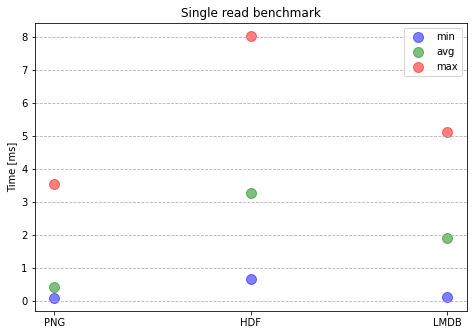

In [82]:
plot_results(results, "Single read benchmark")

### 3.3 Sequential batch read benchmark

In [83]:
results = sequential_batch_benchmark()
print("Results of sequential batch read benchmark [ms]")
print(results)

Results of sequential batch read benchmark [ms]
{'png': {'min': 9.64665412902832, 'max': 19.73438262939453, 'avg': 10.653190612792969}, 'hdf': {'min': 1.6088485717773438, 'max': 2.491474151611328, 'avg': 1.7261672019958496}, 'lmdb': {'min': 0.8058547973632812, 'max': 1.8067359924316406, 'avg': 0.9303188323974609}}


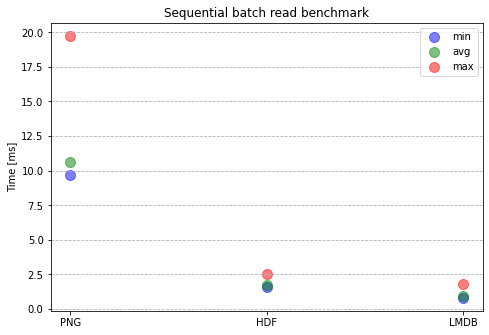

In [84]:
plot_results(results, "Sequential batch read benchmark")

### 3.4 Random batch read benchmark

In [85]:
results = random_batch_benchmark()
print("Results of random batch read benchmark [ms]")
print(results)

Results of random batch read benchmark [ms]
{'png': {'min': 9.74130630493164, 'max': 14.824867248535156, 'avg': 10.583851337432861}, 'hdf': {'min': 3.1538009643554688, 'max': 4.2324066162109375, 'avg': 3.3808398246765137}, 'lmdb': {'min': 1.687765121459961, 'max': 3.113269805908203, 'avg': 1.9166016578674316}}


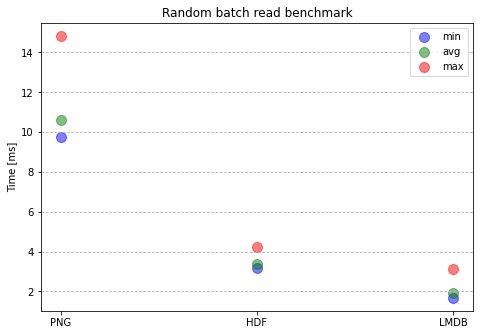

In [86]:
plot_results(results, "Random batch read benchmark")